# THIS USED TO BE CALLED `compare_apo_bfru_histos`
## but since I don't really do that here anymore, I am naming it more appropriately

Here I want to compare the TM7b kinkage

The histograms are in the **same exact** IC and EC area, as the space was based on `F` and `extent` of BFRU simulations

## Note that also here is generally how TM7b moves with TM10/ salt bridges. This is mostly relevant for BFRU simulations, as there we have a population of occluded states etc

# Table of contents:

### TM7b kinks - comparing apo and BFRU
- [TM7b comparisons](#TM7b_compare)
   - Here I calculate the TM7b breakage (by default, the calculation is off because it takes forever to run)
   - Then, load the TM7b angles calculated above and plot them on the FES for both BFRU and apo. 
       - I make these `test_G` scores as I have done before in the sugar clustering analysis. 
       - This function is called `get_df_as_score` and can be used for any dataframe in this analysis really, as long as there is one value per df.loc and there is a `n_frames` column to filter on
- [TM7b breakage vs salt bridge distances](#TM7b_salt_bridge)
- [TM7b and TM10 RMSD](#TM7b_TM10)
   - Run TM10 RMSD, by default off
   - Plot TM10b RMSD on FES, as described above
   - Compare TM7b RMSD to TM10b RMSD by just flattening the `test_G` array that comes from the function, and making a scatter plot on them. I color by state, states come from `sugar_snapshot_prep.ipynb`

### On hold :

- [comparing populations in each grid](#compare_pops) 
   - This just didn't really work, was an idea David and I were playing with
- [contact differences](#contacts)
   - This could still be helpful, I made quite a few contact maps but I just didn't get to finishing this and other things took over

In [1]:
import os
import pickle
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import MDAnalysis as mda
from numpy.linalg import norm
import plot_parameters_for_paper

In [2]:
bfru_sim_dir = "../../string_sims/TMD_initial_path/influx_BFRU_gate_CV"
apo_sim_dir = "../../string_sims/TMD_initial_path/influx_apo_gate_CV"

F_BFRU = np.load(f'{bfru_sim_dir}/F_MSM.npy')
F_apo = np.load(f'{apo_sim_dir}/F_MSM.npy')

extent_BFRU = np.load(f'{bfru_sim_dir}/extent_MSM.npy')
extent_apo = np.load(f'{apo_sim_dir}/extent_MSM.npy')


cv_proj_BFRU = np.load(f'{bfru_sim_dir}/cv_proj_MSM.npy')  #IC, EC
cv_proj_apo = np.load(f'{apo_sim_dir}/cv_proj_MSM.npy')  #IC, EC


cv_labels = ["Intracellular gate (nm)", "Extracellular gate (nm)"]

xlim = (0.9,1.6)
ylim = (0.8,1.6)

In [23]:
condition='apo'
grids=np.arange(0,2916)
savefigs=True
#mpl.rcParams['font.family'] = 'Arial'


In [24]:
def apply_weighted_average(input_list, grid, condition):
    weights = np.loadtxt(f'../confout_files/FES_grids_confouts/influx_{condition}_gate_CV/histogram_{grid}/weights_per_cv_coord.txt',\
                           ndmin=1, \
                           dtype=float)
    
    if len(weights) != len(input_list):
        print('Weights and input list are not the same, something is off')
        return
    
    arr = np.array(input_list)
    
    arr_times_weights = arr * weights
    sum_arr_times_weights = np.sum(arr_times_weights)
    sum_weights = np.sum(weights)
    
    normalized_final = sum_arr_times_weights / sum_weights
    
    return normalized_final    

 <a id='plotting'></a>

# Plotting functions:
1. `get_df_as_score` Take this to plot in same space as F. Got this from `sugar_coordination_analysis`. For now I don't bother making this into a function because there are only 2 variables to plot
2. `plot_FES` Just the usual FES overlay plot
3. `plot_scatter_color_by_state` is what I use for the TM7b vs TM10RMSD, as well as TM10RMSD vs salt bride. This df comes from `sugar_snapshot_prep`

In [25]:
def get_df_as_score(grids,df,selection):
    num = 54
    test_G = np.empty((num, num))
    test_G[:] = np.NaN
    
    row_index = 0
    col_index = 0
    
    frames_filter = 200
    
    for grid in grids:
                
        if grid % num == 0 and grid != 0:
            row_index = row_index + 1 
            col_index = 0
        
        
        # apply a filter for the grids, and run the score
        if df.loc[grid,'n_frames'] > frames_filter:
            score_angle = np.array(df.loc[grid,selection])
        else:
            score_angle = 0 
            
        if score_angle == 0:
            score_angle = np.nan
    

    
        test_G[row_index,col_index] = score_angle
        col_index = col_index + 1
        
    return test_G

In [26]:
def plot_FES(fig, ax, condition, score_to_plot, colormap, vmin, vmax, levels=20, colorbar=False):
    
    xlim = (0.9,1.6)
    ylim = (0.8,1.6)
    
    if condition == 'BFRU':
        F = F_BFRU
        levels_contour=[0,1,1.5,2,3,4]
    elif condition == 'apo':
        F = F_apo
        levels_contour=[0,1,3,5,7]
    
    score_contour = ax.contourf(score_to_plot, 
                               extent=extent_BFRU,
                               cmap=colormap,
                               levels=levels,
                               vmin=vmin,
                               vmax=vmax
                               )
    
    ax.contour(F,
               extent=extent_BFRU,
               vmin=0,
               vmax=15, 
               levels=levels_contour,
               colors='black',
               alpha=0.5
              )
               
    ax.set_xlim(xlim)
    ax.set_ylim(ylim) 
    ax.set_ylabel('Extracellular gate distance (nm)')
    ax.set_xlabel('Intracellular gate distance (nm)')
    
    if colorbar:
        cbar = fig.colorbar(score_contour, ax = ax)
        return cbar, ax
    else:
        return ax

In [27]:
def plot_scatter_color_by_state(ax, xvalue, yvalue,xlim,ylim=(90,160)):
    nearest_grid_to_state = np.load('../textfiles_out/nearest_grid_per_state.npy', allow_pickle=True).item()
    colors = np.zeros(2916)
    colors = colors.astype('str')
    colors[:] = 'grey'
    colors[nearest_grid_to_state['OUT']] = '#5912A3' 
    colors[nearest_grid_to_state['OUT-OCC']] = '#0059E6'
    colors[nearest_grid_to_state['OCC']] = '#0096F5'
    colors[nearest_grid_to_state['IN-OCC']] = '#00A396'
    colors[nearest_grid_to_state['IN']] = '#007359'


    ## plot state vs no state with diff colors and features, also want the states to be on top of the grey, so
    ## give this zorder = 2

    state_marker = np.where(colors[:] != 'grey')
    no_state_marker = np.where(colors[:] == 'grey')



    ax.scatter(xvalue[state_marker], yvalue[state_marker], color=colors[state_marker], \
                edgecolor = 'black', linewidth = 0.3, s = 100, zorder = 2, alpha = 0.9)

    ax.scatter(xvalue[no_state_marker], yvalue[no_state_marker], color=colors[no_state_marker], \
                edgecolor = 'black', linewidth = 0.1, s = 80, zorder = 1, alpha = 0.3)
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

 
 <a id='TM7b_compare'></a>


# Comparing TM7b kinks 


The idea here is that you define 3 points along TM7 and calculate the angle that the vectors of these make. I am copying some of this from `inflecs/inflecs_path_analysis` as this is where we started.

I am not yet sure how we will make this a calculation for everything, probably just do sim by sim and let this run for some hours. For now I will get a working pipeline and then move upwards from there

First thing we want to do is be sure our calculations are correct. We are testing with `influx_apo_gate_CV` and with `histogram_823` which has an angle of 84.08 on frame 1, 87.36 on frame 100, 97.52 on the final frame 194. This angle calculated is between resid 284, 291, 299 and the angle matched in this calculation below

Now we use residue groups to allow for some flexiblity. Residues just chosen on vmd

In [28]:
def theta_of_angle(u, s1, s2, s3):
    A = u.select_atoms(s1).center_of_geometry()
    B = u.select_atoms(s2).center_of_geometry()
    C = u.select_atoms(s3).center_of_geometry()

    BA = A - B
    BC = C - B
    theta = np.arccos(np.dot(BA, BC)/(norm(BA)*norm(BC)))
    return np.rad2deg(theta)

In [29]:
def get_angle(grid, condition, set_name, use_weights = True, backbone = True):
    
    
    ## preprocessing
    if backbone:
        backbone = ' and name CA'
    else:
        backbone = ''
    
    sets_sels = {'set1':['283-285', '290-292', '298-300'],\
                 'set2':['284', '291', '299']
                }
    sels = sets_sels[set_name]
    
    
    
    
    indir = f'../confout_files/FES_grids_confouts/influx_{condition}_gate_CV/histogram_{grid}'    
    if os.path.isfile(f'{indir}/FES_grid_all.xtc'):
        
        print(f'calculating angles for grid {grid}')
        u = mda.Universe(f'../confout_files/tpr_files/influx_{condition}_gate_CV.wholesys.tpr', \
            f'{indir}/FES_grid_all.xtc')
    
        
        theta_u = []
        for ts in u.trajectory:
            theta = theta_of_angle(u, s1 = f'resid {sels[0]}{backbone}', 
                            s2 = f'resid {sels[1]}{backbone}', 
                            s3 = f'resid {sels[2]}{backbone}')

            theta_u.append(theta)        
    
        if use_weights:
            theta_mean = apply_weighted_average(input_list=theta_u, grid=grid, condition=condition)
        else:
            theta_mean = np.mean(theta_u)
        
        outdir=f'../textfiles_out/TM7b_kinkage/influx_{condition}_gate_CV/histogram_{grid}'
        if not os.path.exists(outdir):
            os.mkdir(outdir)
        np.save(f'{outdir}/TM7b_angles_{set_name}.npy', np.array(theta_u))
        
        return [theta_mean, np.std(theta_u), f'{sels} {backbone}', u.trajectory.n_frames]
    
    else:
        return [0, 0, 0, 0]
            

In [30]:
run_calculation = False

In [31]:
set_name = 'set1'
if run_calculation:
    theta_mean_std = {}
    for grid in grids:
        theta_mean_std[grid] = get_angle(grid=grid, 
                                         condition=condition,
                                         set_name=set_name,
                                         use_weights=True,
                                         backbone=True)
        
    angles = pd.DataFrame.from_dict(theta_mean_std, orient = 'index')
    pd.to_pickle(angles, \
        f'../textfiles_out/TM7b_kinkage/influx_{condition}_gate_CV.angles.{set_name}.weighted_average.pkl')

    
use_weighted = True
if use_weighted:
    angles_apo = pd.read_pickle(f'../textfiles_out/TM7b_kinkage/influx_apo_gate_CV.angles.{set_name}.weighted_average.pkl')
    angles_bfru = pd.read_pickle(f'../textfiles_out/TM7b_kinkage/influx_BFRU_gate_CV.angles.{set_name}.weighted_average.pkl')

else:
    angles_apo = pd.read_pickle(f'../textfiles_out/TM7b_kinkage/influx_apo_gate_CV.angles.{set_name}.pkl')
    angles_bfru = pd.read_pickle(f'../textfiles_out/TM7b_kinkage/influx_BFRU_gate_CV.angles.{set_name}.pkl')
    
    
column_names = ['mean_angle','std_angle','res_involved', 'n_frames']
angles_apo.columns = column_names
angles_bfru.columns = column_names

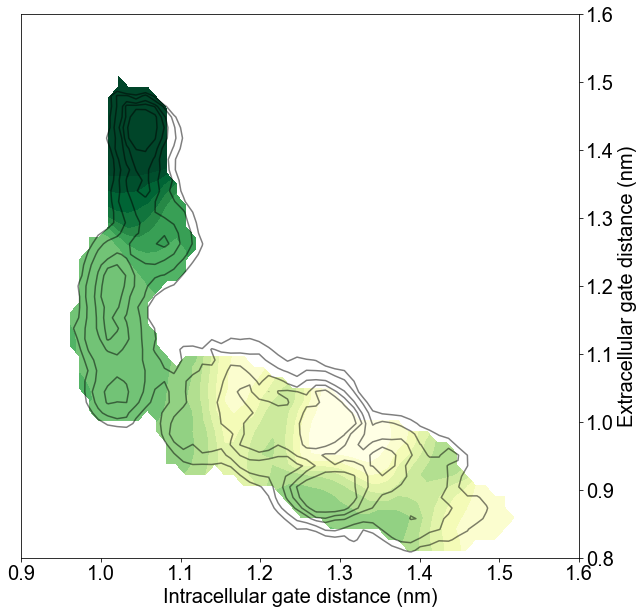

In [35]:
%matplotlib inline
plot_parameters_for_paper.plotting_params()
fig, ax = plt.subplots(1,1, figsize=(10,10))
choice='BFRU'

if choice =='BFRU':
    score = get_df_as_score(grids = list(angles_bfru.index), df = angles_bfru, selection = 'mean_angle')
   # ax.set_title('Fructose-bound TM7b angle')
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    
if choice == 'apo':
    score = get_df_as_score(grids = list(angles_apo.index), df = angles_apo, selection = 'mean_angle')
    #ax.set_title('Apo TM7b angle')
    
plot_FES(fig=fig,
        ax=ax, 
        condition=choice,
        score_to_plot=score,
        colormap='YlGn',
        vmin=95,
        vmax=135)

if savefigs:
    plt.savefig(f'../images_figs/confout_file_analysis/TM7b/TM7b_{choice}.svg', dpi = 1000)

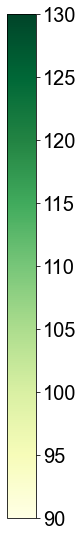

In [47]:
vmin = 90
vmax = 130
plot_parameters_for_paper.plotting_params()
a = np.array([[vmin, vmax]])
plt.figure(figsize=(1, 7))
img = plt.imshow(a, cmap="YlGn")
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.1, 0.4, 1]) #size of colorbar. [?, ?, length, thickness]
plt.colorbar(orientation='vertical', cax=cax,)

if savefigs:
    plt.savefig('../images_figs/confout_file_analysis/TM7b/TM7b_BFRU_vs_apo.scale.svg', bbox_inches = 'tight')

<a id='TM7b_salt_bridge'></a>


# Salt bridge distance

pt 1 - parse

In [36]:
def get_salt_bridge(grid, condition, use_weights = True):
    
    sb_mean = []
    sb_std = []
    
    indir = f'../textfiles_out/salt_bridge_GMX/influx_{condition}_gate_CV/histogram_{grid}'
    weights_f = f'../confout_files/FES_grids_confouts/influx_{condition}_gate_CV/histogram_{grid}/weights_per_cv_coord.txt'
    if os.path.exists(indir):
        for sb_name in sb_names:
            temp = np.loadtxt(f'{indir}/{sb_name}.xvg', ndmin=2)[:,1]
            
            if use_weights:
                sb_mean.append(np.round(apply_weighted_average(input_list=temp, grid=grid, condition=condition),4))
            
            elif not use_weights:
                sb_mean.append(np.round(np.mean(temp), 4))
            
            sb_std.append(np.round(np.std(temp), 4))        
        n_frames = np.shape(temp)[0]
    
    else:
        sb_mean = [0,0,0,0,0]
        sb_std = [0,0,0,0,0]
        n_frames = 0
    
    return sb_mean, sb_std, n_frames

In [37]:
mean_dict = {}
std_dict = {}
n_frames = []
sb_names = ['E145-R91', 'E145-R401', 'E394-R152', 'E394-R334', 'E330-R334']
for grid in grids:
    m,s,n = get_salt_bridge(grid=grid, condition=condition, use_weights=False)
    mean_dict[grid] = m
    std_dict[grid] = s
    n_frames.append(n)
    
    
    
mean_df = pd.DataFrame.from_dict(mean_dict, orient = 'index')
std_df = pd.DataFrame.from_dict(std_dict, orient = 'index')
mean_df.columns = [s + '_mean' for s in sb_names]
std_df.columns = [s + '_std' for s in sb_names]

salt_br = pd.concat([mean_df, std_df], axis = 1)
salt_br['n_frames'] = n_frames

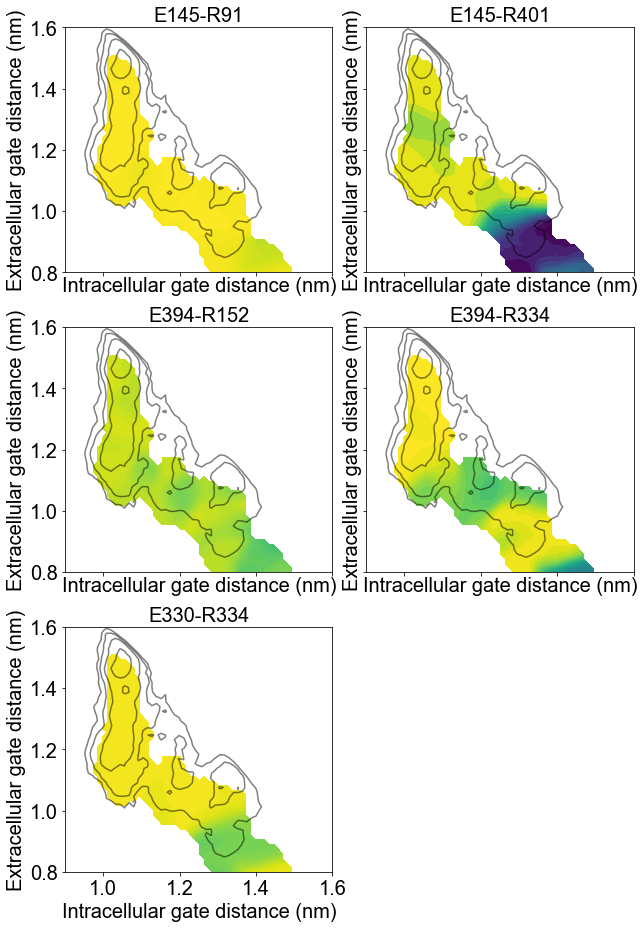

In [38]:
%matplotlib inline


fig,ax=plt.subplots(nrows=3, ncols=2, sharey=True, sharex=True, figsize=(9,13))
ax=np.ravel(ax)

for n, sb_name in enumerate(sb_names):
    temp = get_df_as_score(grids=list(salt_br.index), df = salt_br, selection=f'{sb_name}_mean')
    plot_FES(fig=fig, ax=ax[n], condition=condition, score_to_plot=temp, colormap='viridis_r', levels=20, vmin=0.17, vmax=1.2)
    ax[n].set_title(sb_name)
    

fig.delaxes(ax[5])
plt.tight_layout()

if savefigs:
    pass
    #plt.savefig(f'../images_figs/confout_file_analysis/salt_bridges/{condition}_bridge_on_FES.png')

<a id='TM7b_TM10'></a>

# TM10 displacement



In [39]:
def get_TM10_RMSD(grid, condition, backbone=True, use_weights=True):
    
    import MDAnalysis.analysis.rms as rms
    ref = mda.Universe('../textfiles_out/TM10_RMSD/testing_RMSD/OUT.start.gro')
    if backbone:
        selection='backbone'
    else:
        selection='resid 365-395'
        
        
    indir=f'../confout_files/FES_grids_confouts/influx_{condition}_gate_CV/histogram_{grid}'
    if os.path.isfile(f'{indir}/FES_grid_all.xtc'):
        print(f'calculating RMSD for grid {grid}')
        
        grid_u = mda.Universe(f'{indir}/FES_grid_all.start.pdb', f'{indir}/FES_grid_all.xtc')
        R = rms.RMSD(reference = ref, 
                atomgroup = grid_u, 
                select = selection, 
                center = True, 
                groupselections = ['resid 385-395']
               )
        
        R.run()
        rmsd = R.rmsd
        
        if use_weights:
            bb_rmsd_mean = apply_weighted_average(input_list=rmsd[:,2], grid=grid, condition=condition)
            tm10_b_rmsd_mean = apply_weighted_average(input_list=rmsd[:,3], grid=grid, condition=condition)
        else:            
            bb_rmsd_mean = np.mean(rmsd[:,2])
            tm10_b_rmsd_mean = np.mean(rmsd[:,3])
            
        bb_rmsd_std = np.std(rmsd[:,2])
        tm10_b_rmsd_std = np.std(rmsd[:,3])
        n_frames = np.shape(rmsd)[0]
        
        
        outdir=f'../textfiles_out/TM10_RMSD/influx_{condition}_gate_CV/histogram_{grid}'
        if not os.path.exists(outdir):
            os.mkdir(outdir)
        np.save(f'{outdir}/RMSD_{selection}_TM10b_.npy', rmsd)
        
        
        
        return [bb_rmsd_mean, bb_rmsd_std, tm10_b_rmsd_mean, tm10_b_rmsd_std, n_frames]
    else:
        print(f'no confout in grid {grid}')
        return [0,0,0,0,0]

In [40]:
run_calculation = False

In [41]:
if run_calculation: 
    rmsd_backbone_fit_dict = {}
    for grid in grids:
        rmsd_backbone_fit_dict[grid] = get_TM10_RMSD(grid=grid,
                                                     condition=condition,
                                                     backbone=True,
                                                     use_weights=True)
        
    rmsd_backbone_fit_df = pd.DataFrame.from_dict(rmsd_backbone_fit_dict, orient = 'index')
    pd.to_pickle(rmsd_backbone_fit_df, \
        f'../textfiles_out/TM10_RMSD/influx_{condition}_gate_CV.rmsd_backbone_fit.weighted_average.pkl')

    
    
indir='../textfiles_out/TM10_RMSD/'
if use_weighted:
    rmsd_tm10_bfru = pd.read_pickle(f'{indir}/influx_BFRU_gate_CV.rmsd_backbone_fit.weighted_average.pkl')
    rmsd_tm10_apo = pd.read_pickle(f'{indir}/influx_apo_gate_CV.rmsd_backbone_fit.weighted_average.pkl')
else:
    rmsd_tm10_bfru = pd.read_pickle(f'{indir}/influx_BFRU_gate_CV.rmsd_backbone_fit_dict.pkl')
    rmsd_tm10_apo = pd.read_pickle(f'{indir}/influx_apo_gate_CV.rmsd_backbone_fit_dict.pkl')
    
column_names = ['backbone_rmsd_mean','backbone_rmsd_std','tm10b_rmsd_mean', 'tm10b_rmsd_std', 'n_frames']
rmsd_tm10_bfru.columns = column_names
rmsd_tm10_apo.columns = column_names

Plotting functions from [here](#plotting)

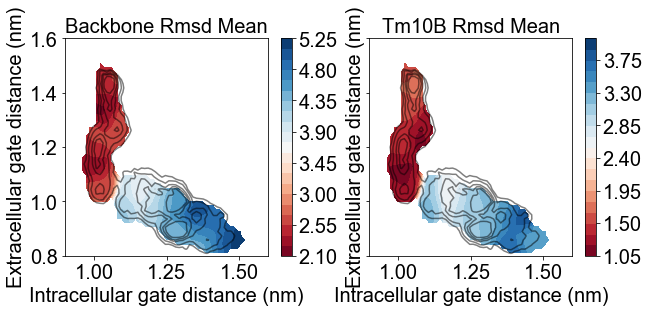

In [42]:
%matplotlib inline

fig,ax = plt.subplots(nrows = 1, ncols = 2, sharey = True, figsize = (10,4))

selections=['backbone_rmsd_mean','tm10b_rmsd_mean']

for n in np.arange(0,len(selections)):
    score=get_df_as_score(grids = list(rmsd_tm10_bfru.index), \
                               df = rmsd_tm10_bfru, selection = selections[n])
    plot_FES(fig=fig, 
            ax=ax[n], 
            condition=choice,
            score_to_plot=score,
            colormap='RdBu',
            vmin=None,
            vmax=None,
            colorbar=True)
    ax[n].set_title(' '.join(selections[n].split('_')).title())

plt.show()

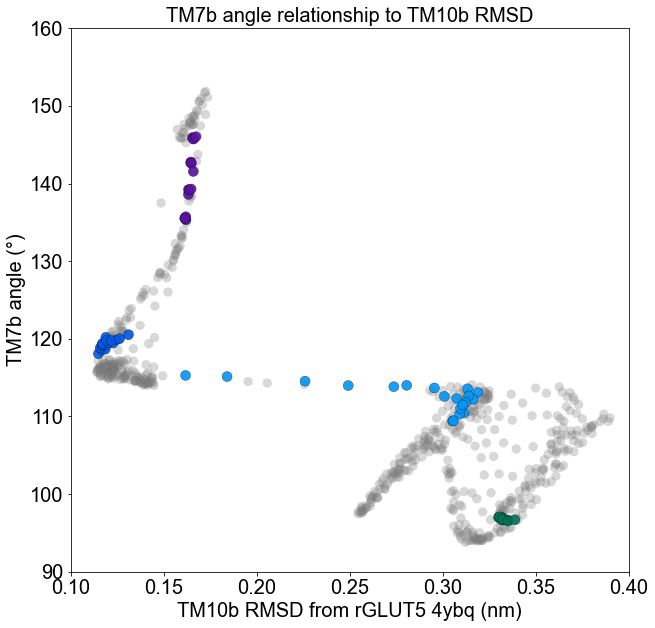

In [44]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
plot_parameters_for_paper.plotting_params()
tm10b = np.ravel(get_df_as_score(grids = list(rmsd_tm10_bfru.index), \
                               df = rmsd_tm10_bfru, selection = 'tm10b_rmsd_mean'))
tm10b = tm10b/10
tm7_angle = np.ravel(get_df_as_score(grids = list(angles_bfru.index),\
                                df = angles_bfru, selection = 'mean_angle'))

plot_scatter_color_by_state(ax=ax, 
                            xvalue=tm10b,
                            yvalue=tm7_angle,
                            xlim=(0.1,0.4))

ax.set_xlabel('TM10b RMSD from rGLUT5 4ybq (nm)')
ax.set_ylabel('TM7b angle (°)')
ax.set_title('TM7b angle relationship to TM10b RMSD')

if savefigs:
    plt.savefig('../images_figs/confout_file_analysis/TM7b/TM7b_BFRU_and_TM7b_vs_TM10_RMSD.state_colors.svg',\
                dpi = 1000)

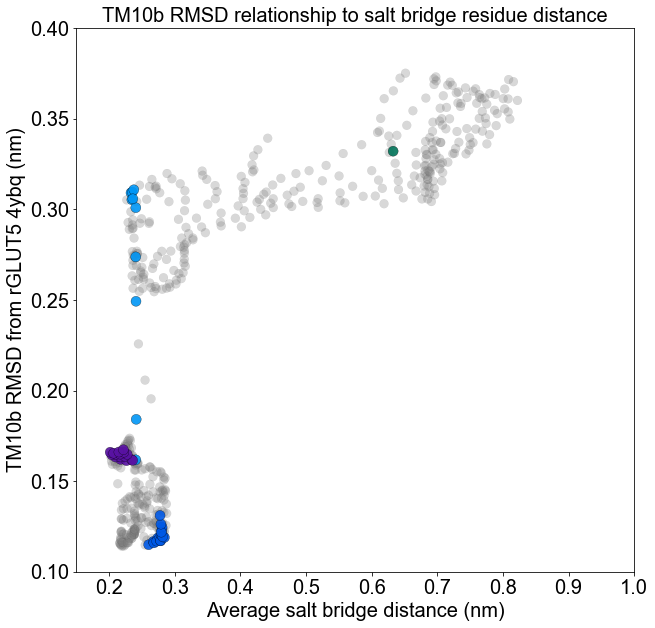

In [45]:
salt_br_score = np.ravel(np.mean(np.array([get_df_as_score(grids = list(salt_br.index), df = salt_br, selection = 'E145-R401_mean'),
                        get_df_as_score(grids = list(salt_br.index), df = salt_br, selection = 'E394-R152_mean')]),
                        axis = 0))

f,ax = plt.subplots(1,1,figsize = (10,10))
plot_parameters_for_paper.plotting_params()
plot_scatter_color_by_state(ax=ax, 
                            xvalue=salt_br_score,
                            yvalue=tm10b,
                            xlim=(0.15,1),
                            ylim=(0.1,0.4))

plt.xlabel('Average salt bridge distance (nm)')
plt.ylabel('TM10b RMSD from rGLUT5 4ybq (nm)')
plt.title('TM10b RMSD relationship to salt bridge residue distance')
if savefigs:
    plt.savefig('../images_figs/confout_file_analysis/salt_bridges/BFRU.salt_bridge_dist_vs_TM10b_RMSD.svg',\
                dpi = 1000)

# Pt. 3 - RMSD to each other

I would like to be able to compare the overall RMSD of these proteins to each other in each grid. Currently, I am not exactly sure how I should go about doing that. Maybe take a central conformation for each and then calc RMSD between that? Take 100 random configs from both and get their RMSD to each other?? Need to think


 # ON HOLD FOR NOW


<a id='compare_pops'></a>


# simple comparison to see the # data points in each histo box

This could say that for example, in inward occluded that it was way more visited in BFRU than apo. 

## NOTE - this didn't really work in the end, I move it to the bottom

These functions are from `sugar_snapshots_prep`

In [3]:
def get_square(data, IC_leftmost, IC_rightmost, EC_lowermost, EC_uppermost, IC_index, EC_index):
    '''
    IC index should be 0 or 1 depending on where it exists in data, same for EC
    '''
    
    col0m = np.logical_and(data[:,IC_index]>= IC_leftmost, data[:,IC_index]<=IC_rightmost) #IC column mask
    col1m = np.logical_and(data[:,EC_index]>= EC_lowermost, data[:,EC_index]<=EC_uppermost) #EC column mask

    col0_1 = data[col0m & col1m]
    
    IC_selected_region = col0_1[:,IC_index]
    EC_selected_region = col0_1[:,EC_index]
    
    return IC_selected_region, EC_selected_region

In [4]:
def get_grid_square(grid, cv_proj):
    IC_extent = np.linspace(extent_BFRU[0], extent_BFRU[1], 55)
    EC_extent = np.linspace(extent_BFRU[2], extent_BFRU[3], 55)

    # define square
    grid_label = 0
    grid_label_coord_dict = {}

    for y_grid_index in range(0, 55):
        for x_grid_index in range(0, 55):
            if x_grid_index < 54 and y_grid_index < 54:
                IC_leftmost = IC_extent[x_grid_index] - 0.01
                IC_rightmost = IC_extent[x_grid_index + 1] + 0.01
                EC_uppermost = EC_extent[y_grid_index + 1] + 0.01
                EC_lowermost = EC_extent[y_grid_index] - 0.01

                coords = [IC_leftmost, IC_rightmost, EC_uppermost, EC_lowermost]    
                grid_label_coord_dict[grid_label] = coords
                grid_label = grid_label + 1

    IC_leftmost, IC_rightmost, EC_uppermost, EC_lowermost = grid_label_coord_dict[grid]            
    
    
    
    
    
    #Get the IC&EC gate values where F is within specified range
    min_F = -1
    max_F = 15
    IC_min_indices = np.where(np.logical_and(F_BFRU > min_F, F_BFRU < max_F))[1]
    EC_min_indices = np.where(np.logical_and(F_BFRU > min_F, F_BFRU < max_F))[0]

    IC_min_vals = []
    EC_min_vals = []
    for val_IC, val_EC in zip(IC_extent[IC_min_indices], EC_extent[EC_min_indices]):
        IC_min_vals.append(val_IC)
        EC_min_vals.append(val_EC)

    all_min_vals = np.vstack((IC_min_vals, EC_min_vals)).T

    IC_selected_region, EC_selected_region = get_square(data = all_min_vals,
                                                        IC_leftmost=IC_leftmost,
                                                        IC_rightmost=IC_rightmost,
                                                        EC_lowermost=EC_lowermost,
                                                        EC_uppermost=EC_uppermost,
                                                        IC_index=0,
                                                        EC_index=1)

    all_min_vals_selected_region = np.vstack((IC_selected_region, EC_selected_region)).T
    
    
    
    
    
    
    ###### get where data is fitting square
    margin = np.diff(IC_extent)[0]/2 + 0.001  #dist between each point + a bit extra

    data = cv_proj[:,1,:] ## wondering if you need to only take the drift value of swarms, not starting...

    all_nearby_minima_square = []
    all_nearby_indices = []

    for IC_region_bead, EC_region_bead in all_min_vals_selected_region:
        IC_nearby = np.logical_and(data[:,0]>(IC_region_bead-margin), data[:,0]<(IC_region_bead+margin))
        EC_nearby = np.logical_and(data[:,1]>(EC_region_bead-margin), data[:,1]<(EC_region_bead+margin))
        all_nearby_minima_square.append(data[IC_nearby & EC_nearby])
        all_nearby_indices.append(np.where(IC_nearby & EC_nearby)[0])

    all_nearby_minima_square = np.array(all_nearby_minima_square)
    all_nearby_minima_square = np.concatenate(all_nearby_minima_square)

    all_nearby_indices = np.array(all_nearby_indices)
    all_nearby_indices = np.concatenate(all_nearby_indices)

    print(np.shape(all_nearby_minima_square))
    
    
    return grid_label_coord_dict, all_nearby_minima_square, all_min_vals_selected_region

The influx BFRU has run much shorter than apo, so apo has more chances to get to a certain state. Therefore, we want to express this state visiting in a percentage

(739, 2)
(208, 2)
Frequency for this state at grid 823 is 0.072 % for apo
Frequency for this state at grid 823 is 0.364 % for BFRU
Difference between these frequencies is 0.29 %
(2456, 2)
(3542, 2)
Frequency for this state at grid 2223 is 1.224 % for apo
Frequency for this state at grid 2223 is 1.21 % for BFRU
Difference between these frequencies is 0.01 %
(1981, 2)
(3025, 2)
Frequency for this state at grid 730 is 1.045 % for apo
Frequency for this state at grid 730 is 0.976 % for BFRU
Difference between these frequencies is 0.07 %
(175, 2)
(44, 2)
Frequency for this state at grid 155 is 0.015 % for apo
Frequency for this state at grid 155 is 0.086 % for BFRU
Difference between these frequencies is 0.07 %
2022-03-22 11:11:56 matplotlib.font_manager-DEBUG: findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2022-03-22 11:11:56 matplotlib.font_manager-DEBUG: findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 n

2022-03-22 11:11:56 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Noto Sans CJK JP' (NotoSansCJK-Regular.ttc) normal normal 400 normal>) = 10.05
2022-03-22 11:11:56 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Liberation Mono' (LiberationMono-Italic.ttf) italic normal 400 normal>) = 11.05
2022-03-22 11:11:56 matplotlib.font_manager-DEBUG: findfont: score(<Font 'KacstTitleL' (KacstTitleL.ttf) normal normal 400 normal>) = 10.05
2022-03-22 11:11:56 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Noto Sans CJK JP' (NotoSansCJK-Medium.ttc) normal normal 500 normal>) = 10.145
2022-03-22 11:11:56 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Lato' (Lato-ThinItalic.ttf) italic normal 200 normal>) = 11.24
2022-03-22 11:11:56 matplotlib.font_manager-DEBUG: findfont: score(<Font 'STIXVariants' (STIXVariants-Regular.otf) normal normal 400 normal>) = 10.05
2022-03-22 11:11:56 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Umpush' (Umpush-Bold.ttf) normal normal

2022-03-22 11:11:56 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Abyssinica SIL' (AbyssinicaSIL-R.ttf) normal normal 400 normal>) = 10.05
2022-03-22 11:11:56 matplotlib.font_manager-DEBUG: findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
2022-03-22 11:11:56 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Norasi' (Norasi-Oblique.ttf) oblique normal 400 normal>) = 11.05
2022-03-22 11:11:56 matplotlib.font_manager-DEBUG: findfont: score(<Font 'STIXIntegralsD' (STIXIntegralsD-Bold.otf) normal normal 700 normal>) = 10.335
2022-03-22 11:11:56 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Liberation Mono' (LiberationMono-BoldItalic.ttf) italic normal 700 normal>) = 11.335
2022-03-22 11:11:56 matplotlib.font_manager-DEBUG: findfont: score(<Font 'FreeSans' (FreeSans.ttf) normal normal 400 normal>) = 10.05
2022-03-22 11:11:56 matplotlib.font_manager-DEBUG: findfont: score(<Font 'KacstDecorative' (KacstDecorative.ttf) normal normal 5

2022-03-22 11:11:56 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Ubuntu' (Ubuntu-LI.ttf) italic normal 300 normal>) = 11.145
2022-03-22 11:11:56 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Tlwg Typewriter' (TlwgTypewriter-Oblique.ttf) oblique normal 400 normal>) = 11.05
2022-03-22 11:11:56 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Lato' (Lato-Light.ttf) normal normal 300 normal>) = 10.145
2022-03-22 11:11:56 matplotlib.font_manager-DEBUG: findfont: score(<Font 'KacstFarsi' (KacstFarsi.ttf) normal normal 500 normal>) = 10.145
2022-03-22 11:11:56 matplotlib.font_manager-DEBUG: findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-BoldOblique.ttf) oblique normal 700 condensed>) = 1.535
2022-03-22 11:11:56 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Khmer OS' (KhmerOS.ttf) normal normal 400 normal>) = 10.05
2022-03-22 11:11:56 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Lato' (Lato-Hairline.ttf) normal normal 100 normal>) = 10.335
2022-

2022-03-22 11:11:56 matplotlib.font_manager-DEBUG: findfont: score(<Font 'KacstBook' (KacstBook.ttf) normal normal 500 normal>) = 10.145
2022-03-22 11:11:56 matplotlib.font_manager-DEBUG: findfont: score(<Font 'STIXSizeThreeSym' (STIXSizeThreeSym-Regular.otf) normal normal 400 normal>) = 10.05
2022-03-22 11:11:56 matplotlib.font_manager-DEBUG: findfont: score(<Font 'STIXIntegralsUp' (STIXIntegralsUp-Bold.otf) normal normal 700 normal>) = 10.335
2022-03-22 11:11:56 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Norasi' (Norasi-BoldItalic.ttf) italic normal 700 normal>) = 11.335
2022-03-22 11:11:56 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Laksaman' (Laksaman-Italic.ttf) italic normal 400 normal>) = 11.05
2022-03-22 11:11:56 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Padauk Book' (Padauk-bookbold.ttf) normal normal 700 normal>) = 10.335
2022-03-22 11:11:56 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Kinnari' (Kinnari-Italic.ttf) italic normal 500 n

/tmp/ipykernel_21692/3784581778.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_nearby_minima_square = np.array(all_nearby_minima_square)
/tmp/ipykernel_21692/3784581778.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_nearby_indices = np.array(all_nearby_indices)


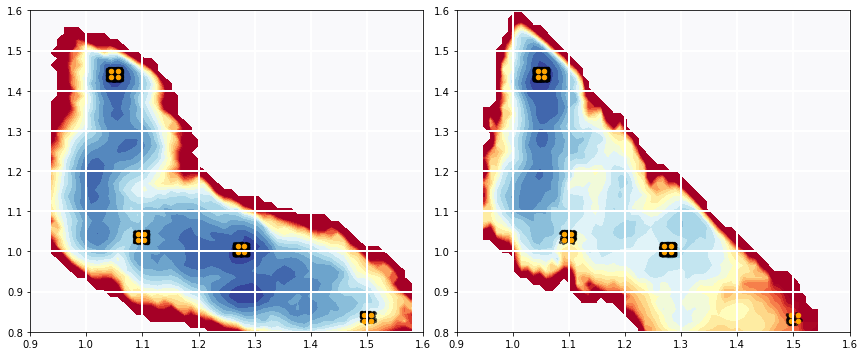

In [5]:
%matplotlib inline

f_max = 15

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,5))

ax[0].contourf(F_BFRU, extent = extent_BFRU, vmin = 0, vmax = f_max, levels = 50, cmap = 'RdYlBu_r')
ax[1].contourf(F_apo, extent = extent_apo, vmin = 0, vmax = f_max, levels = 50, cmap = 'RdYlBu_r')



grids = [823,2223,730,155]

for grid in grids:
    grid_label_coord_dict, black_data_B, orange_data_B = get_grid_square(grid, cv_proj = cv_proj_BFRU)
    grid_label_coord_dict, black_data_a, orange_data_a = get_grid_square(grid, cv_proj = cv_proj_apo)

    apo_state_frequency = (np.shape(black_data_a)[0] / np.shape(cv_proj_apo)[0]) * 100
    BFRU_state_frequency = (np.shape(black_data_B)[0] / np.shape(cv_proj_BFRU)[0]) * 100

    print(f"Frequency for this state at grid {grid} is {np.round(apo_state_frequency , 3)} % for apo")
    print(f"Frequency for this state at grid {grid} is {np.round(BFRU_state_frequency , 3)} % for BFRU")
    print(f"Difference between these frequencies is {np.round(np.abs(apo_state_frequency - BFRU_state_frequency),2)} %")

    ax[0].scatter(black_data_B[:,0], black_data_B[:,1], s = 5, alpha = 0.5, c = 'black')
    ax[0].scatter(orange_data_B[:,0], orange_data_B[:,1], c = 'orange',s = 20)


    ax[1].scatter(black_data_a[:,0], black_data_a[:,1], s = 5, alpha = 0.5, c = 'black')
    ax[1].scatter(orange_data_a[:,0], orange_data_a[:,1], c = 'orange',s = 20)


fig.tight_layout()

ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)


ax[1].set_xlim(xlim)
ax[1].set_ylim(ylim)

plt.show()

<a id='contacts'></a>

# Pt. 4 - contact differences between the conditions

## on hold because I prioritized other things

I would also like to be able to compare the contacts formed in these simulations and what the difference is between them 

I think for representing this, we would just make a contact matrix using gmx pairdist or whatever, and then subtract the differences for each histo. I don't actually care about what the distances are, just the differences between them.

How to represent it, is a different question... 

## I am going to try Darko's method

```
from scipy.spatial.distances import cdist

for i,resi in enumerate(protein):
    for j,resj in enumerate(protein):
        """ here, resi and resj are arrays containing the atomic coordinates of residue i and j.
               cdist finds pair-wise distances between all involved atoms"""
        contact_map[i,j]  =  np.min(cdist(resi,resj))
```

this is what he suggests, where protein is an mdanalysis object


### That part is now in a python script called contact_matrix_calculation.py. Below we then parse the info from there


In [29]:
calc_means = False

if calc_means:
    mean_contact_BFRU = np.zeros((2916,474,474))
    mean_contact_apo = np.zeros((2916,474,474))
    
    for grid in np.arange(0,2916):
        infile_BFRU = f'../textfiles_out/contact_maps/influx_BFRU_gate_CV/histogram_{grid}.contact_map_all.npy'
        infile_apo = f'../textfiles_out/contact_maps/influx_apo_gate_CV/histogram_{grid}.contact_map_all.npy'
        if os.path.exists(infile_BFRU) and os.path.exists(infile_apo):
            print(grid)
            mean_contact_BFRU[grid] = (np.mean(np.load(infile_BFRU), axis = 0))
            mean_contact_apo[grid] = (np.mean(np.load(infile_apo), axis = 0))

    np.save('../textfiles_out/contact_maps/influx_BFRU_gate_CV/mean_contact_BFRU.npy', mean_contact_BFRU)
    np.save('../textfiles_out/contact_maps/influx_apo_gate_CV/mean_contact_apo.npy', mean_contact_apo)
    

else:
    mean_contact_BFRU = np.load('../textfiles_out/contact_maps/influx_BFRU_gate_CV/mean_contact_BFRU.npy')
    mean_contact_apo = np.load('../textfiles_out/contact_maps/influx_apo_gate_CV/mean_contact_apo.npy')

### representation:
Here I want to plot the differences between these on our classic FES maps, as I think this could be effective. For this we would have to choose a certain region of differences and then average this

We can also plot this as a function of grid # , and res pairs on y axis and then color by diff. Obviously it would be a lot of residue pairs though

You could also do a classic contact map as the difference averaged between some grids

In [48]:
diff_contacts = mean_contact_BFRU - mean_contact_apo

In [93]:
# first, turn everything that is not of interest to 0
further_contacts = np.copy(diff_contacts)
closer_contacts = np.copy(diff_contacts)

further_contacts[further_contacts <= 5] = 0
closer_contacts[closer_contacts >= -5] = 0

# then number the parts of interest to be grid # so we can color by this
for grid in range(0,2916):
    further_contacts[grid][further_contacts[grid] != 0] = grid
    closer_contacts[grid][closer_contacts[grid] != 0] = grid
    print(grid, np.where(further_contacts[grid]), np.where(closer_contacts[grid]))

#further_contacts[further_contacts == 0] = np.nan
#closer_contacts[closer_contacts == 0] = np.nan

0 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
3 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
4 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
5 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
6 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
7 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
8 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
9 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))


79 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
80 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
81 (array([  0,   0,   0, ..., 472, 473, 473]), array([179, 296, 297, ..., 219, 218, 219])) (array([  0,   0,   0, ..., 473, 473, 473]), array([ 50,  52,  82, ..., 450, 451, 452]))
82 (array([  0,   0,   0, ..., 472, 473, 473]), array([179, 288, 295, ..., 219, 218, 219])) (array([  0,   0,   0, ..., 473, 473, 473]), array([ 50,  83, 214, ..., 397, 398, 449]))
83 (array([  0,   0,   0, ..., 472, 473, 473]), array([179, 295, 296, ..., 219, 218, 219])) (array([  0,   0,   0, ..., 473, 473, 473]), array([ 50,  83,  85, ..., 397, 398, 449]))
84 (array([  0,   0,   0, ..., 472, 473, 473]), array([179, 288, 295, ..., 220, 218, 219])) (array([  0,   0,   0, ..., 473, 473, 473]), array([ 50,  82,  83, ..., 446, 449, 450]))
85 (array([  0,   0,   0, ..., 472, 473, 473]), array([297, 300, 301, ...,

159 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
160 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
161 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
162 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
163 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
164 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
165 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
166 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
167 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
168 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), arra

242 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
243 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
244 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
245 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
246 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
247 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
248 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
249 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
250 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
251 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), arra

330 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
331 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
332 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
333 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
334 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
335 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
336 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
337 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
338 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
339 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), arra

421 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
422 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
423 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
424 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
425 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
426 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
427 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
428 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
429 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
430 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), arra

509 (array([  0,   1,   1, ..., 473, 473, 473]), array([177,  46,  52, ..., 361, 431, 432])) (array([  0,   0,   0, ..., 473, 473, 473]), array([  8,  18,  76, ..., 251, 252, 253]))
510 (array([  1,   2,   2, ..., 473, 473, 473]), array([ 52, 233, 234, ..., 357, 361, 432])) (array([  0,   0,   0, ..., 473, 473, 473]), array([  8,   9,  12, ..., 253, 255, 396]))
511 (array([  2,   2,   3, ..., 456, 457, 458]), array([233, 234, 233, ..., 206,  14,  14])) (array([  0,   0,   0, ..., 473, 473, 473]), array([  8,   9,  18, ..., 252, 253, 255]))
512 (array([  2,   2,   3, ..., 456, 456, 457]), array([232, 233, 233, ..., 206, 397,  14])) (array([  0,   0,   0, ..., 473, 473, 473]), array([ 57,  61, 110, ..., 251, 252, 253]))
513 (array([  2,   2,   3, ..., 457, 457, 457]), array([232, 233, 233, ...,  14, 205, 206])) (array([  0,   0,   0, ..., 473, 473, 473]), array([ 57,  61, 111, ..., 401, 402, 403]))
514 (array([  2,   2,   3, ..., 458, 459, 467]), array([232, 233, 233, ..., 406, 406, 208]

551 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
552 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
553 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
554 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
555 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
556 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
557 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
558 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
559 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
560 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), arra

643 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
644 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
645 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
646 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
647 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
648 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
649 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
650 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
651 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
652 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), arra

735 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
736 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
737 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
738 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
739 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
740 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
741 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
742 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
743 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
744 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), arra

827 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
828 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
829 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
830 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
831 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
832 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
833 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
834 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
835 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
836 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), arra

919 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
920 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
921 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
922 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
923 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
924 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
925 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
926 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
927 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
928 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), arra

1008 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1009 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1010 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1011 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1012 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1013 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1014 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1015 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1016 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1017 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=in

1048 (array([  0,   0,   0, ..., 472, 472, 472]), array([ 21,  22,  24, ..., 240, 241, 244])) (array([ 31,  32,  33,  34,  35,  36,  38,  39,  40,  41,  42,  42,  43,
        43,  44,  44,  44,  45,  45,  45,  45,  45,  45,  45,  45,  45,
        45,  46,  46,  46,  46,  46,  46,  46,  46,  46,  48,  48,  48,
        48,  48,  51,  51,  52,  52,  55,  55,  57,  57,  57,  57,  58,
        58,  60,  61,  61,  63,  64,  65,  66,  67,  68,  69,  72,  72,
        73,  73,  74,  75,  76,  76,  77,  78,  79,  80,  81,  82,  83,
       100, 114, 115, 115, 116, 117, 117, 117, 118, 119, 120, 120, 121,
       121, 122, 122, 124, 124, 124, 124, 125, 125, 129, 132, 159, 175,
       175, 175, 175, 175, 176, 176, 176, 177, 177, 177, 177, 177, 177,
       177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177,
       177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177,
       177, 178, 178, 178, 179, 179, 179, 179, 180, 180, 184, 184, 197,
       214, 230, 230, 230, 230, 230, 230,

1091 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1092 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1093 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1094 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1095 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1096 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1097 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1098 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1099 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1100 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=in

1181 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1182 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1183 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1184 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1185 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1186 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1187 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1188 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1189 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1190 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=in

1263 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1264 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1265 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1266 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1267 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1268 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1269 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1270 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1271 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1272 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=in

1345 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1346 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1347 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1348 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1349 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1350 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1351 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1352 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1353 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1354 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=in

1427 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1428 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1429 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1430 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1431 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1432 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1433 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1434 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1435 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1436 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=in

1509 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1510 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1511 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1512 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1513 (array([  0,   0,   0, ..., 471, 471, 471]), array([ 49, 284, 330, ...,  46,  49, 179])) (array([ 43,  43,  52,  53,  53,  57,  61, 159, 160, 176, 254, 254, 254,
       258, 285, 289, 290, 291, 291, 292, 293, 294, 295, 296, 297, 298,
       299, 300, 301, 302, 306, 307, 308, 309, 310, 312, 313, 314, 315,
       316, 317, 318, 319, 321, 322, 323, 324, 334, 338, 343, 346, 355,
       361, 363, 364, 373, 376, 379, 383, 424, 426, 428, 448, 449, 450,
       473, 473, 473, 473, 473, 473, 473, 473, 473, 473, 473, 473, 473,
       473, 473, 473, 473, 473, 473, 473, 473, 473, 473, 473,

1544 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1545 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1546 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1547 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1548 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1549 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1550 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1551 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1552 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1553 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=in

1580 (array([  0,   0,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   2,   2,
         3,   3,   4,   4,   5,   6,   7,   9,  10,  11,  11,  12,  13,
        13,  14,  14,  15,  16,  17,  17,  18,  19,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  29,  30,  32,  34,  35,  35,  36,  36,
        37,  37,  38,  39,  40,  40,  41,  42,  43,  43,  44,  44,  45,
        45,  46,  46,  46,  47,  49,  50,  51,  51,  52,  53,  54,  55,
        56,  57,  57,  58,  59,  60,  61,  62,  63,  63,  64,  65,  66,
        67,  67,  70,  73,  76,  77,  78,  80,  81,  82,  85,  93,  94,
        97,  98,  99, 101, 102, 104, 105, 106, 108, 109, 110, 111, 112,
       112, 117, 117, 117, 117, 120, 121, 123, 124, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       142, 143, 144, 146, 147, 148, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 160, 161, 163, 164, 166, 167, 168, 1

1621 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1622 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1623 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1624 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1625 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1626 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1627 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1628 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1629 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1630 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=in

1703 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1704 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1705 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1706 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1707 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1708 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1709 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1710 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1711 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1712 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=in

1787 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1788 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1789 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1790 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1791 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1792 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1793 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1794 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1795 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1796 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=in

1870 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1871 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1872 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1873 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1874 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1875 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1876 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1877 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1878 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1879 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=in

1952 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1953 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1954 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1955 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1956 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1957 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1958 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1959 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1960 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
1961 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=in

2041 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2042 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2043 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2044 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2045 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2046 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2047 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2048 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2049 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2050 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=in

2084 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2085 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2086 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2087 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2088 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2089 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2090 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2091 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2092 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2093 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=in

2173 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2174 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2175 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2176 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2177 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2178 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2179 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2180 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2181 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2182 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=in

2263 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2264 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2265 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2266 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2267 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2268 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2269 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2270 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2271 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2272 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=in

2353 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2354 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2355 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2356 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2357 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2358 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2359 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2360 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2361 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2362 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=in

2443 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2444 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2445 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2446 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2447 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2448 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2449 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2450 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2451 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2452 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=in

2534 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2535 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2536 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2537 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2538 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2539 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2540 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2541 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2542 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2543 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=in

2626 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2627 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2628 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2629 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2630 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2631 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2632 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2633 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2634 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2635 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=in

2718 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2719 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2720 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2721 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2722 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2723 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2724 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2725 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2726 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2727 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=in

2810 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2811 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2812 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2813 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2814 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2815 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2816 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2817 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2818 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2819 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=in

2896 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2897 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2898 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2899 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2900 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2901 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2902 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2903 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2904 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
2905 (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=in

2022-02-15 14:08:09 matplotlib.colorbar-DEBUG: locator: <matplotlib.ticker.FixedLocator object at 0x7f2fc6fca790>
2022-02-15 14:08:09 matplotlib.colorbar-DEBUG: Using auto colorbar locator <matplotlib.ticker.FixedLocator object at 0x7f2fc6fca790> on colorbar
2022-02-15 14:08:09 matplotlib.colorbar-DEBUG: Setting pcolormesh


[Text(1, 0.0, '0.0'),
 Text(1, 0.25, '729.0'),
 Text(1, 0.5, '1458.0'),
 Text(1, 0.75, '2187.0'),
 Text(1, 1.0, '2916.0')]

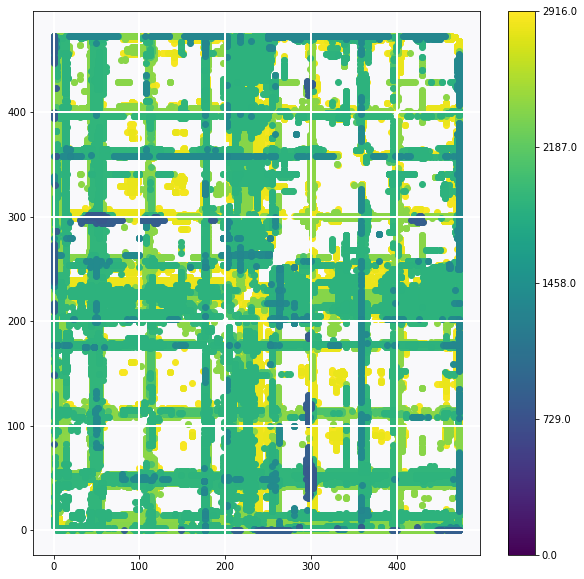

In [102]:
colormap_colors = 'viridis_r'
cmap_vals = plt.cm.get_cmap(colormap_colors)
color_vals = cmap_vals(np.linspace(0,1,2916))

f, ax = plt.subplots(figsize=(10,10))

for grid in range(0,2916):
    test = np.vstack(np.where(closer_contacts[grid])).T
    scat = ax.scatter(test[:,0], test[:,1], color = color_vals[grid])

ticks = [0, 0.25, 0.5, 0.75, 1]
cbar = f.colorbar(scat, ticks=ticks)
cbar.ax.set_yticklabels(list(2916 * np.array(ticks)))  

In [113]:
test = np.vstack(np.where(closer_contacts[99])).T
